In [3]:
# Método de previsão de espectro utilizando convoluções
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp

# retirar estas duas linhas se não tiver o jupyterthemes instalado
from jupyterthemes import jtplot
jtplot.style(context="paper", ticks=True, grid=True)

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams.update({'font.size': 22})

In [4]:
# Load the spectral lines data
Data_Hg= np.transpose( np.loadtxt("Lines_Hg.csv", delimiter=";") )
Data_Kr= np.transpose( np.loadtxt("Lines_Kr.csv", delimiter=";") )
Data_Ne= np.transpose( np.loadtxt("Lines_Ne.csv", delimiter=";") )
Data_He= np.transpose( np.loadtxt("Lines_He.csv", delimiter=";") )
Data_Ar= np.transpose( np.loadtxt("Lines_Ag.csv", delimiter=";") )

# Load the experimental data
PATH="C:\\Users\\jonny\\Uni\\2S\\LAC\\Projeto\\DadosExperimentais\\PraiseThe"
Hg= np.loadtxt( PATH+"Mercurio" )
Ar= np.loadtxt( PATH+"Argon" )
He= np.loadtxt( PATH+"Helio" )
Ne= np.loadtxt( PATH+"Neon" )
Kr= np.loadtxt( PATH+"Kripton" )

# Ajuste v2.2, verificar se há versão mais atualizada no ficheiro de ajuste
Nosso= np.array((315.57001167007337,+2.17551118793287,+0.008588338277613293,
                           -8.62291127124621e-05,+2.9828358440805296e-07,-3.9133329397982944e-10))
F= np.polynomial.polynomial.Polynomial(Nosso)

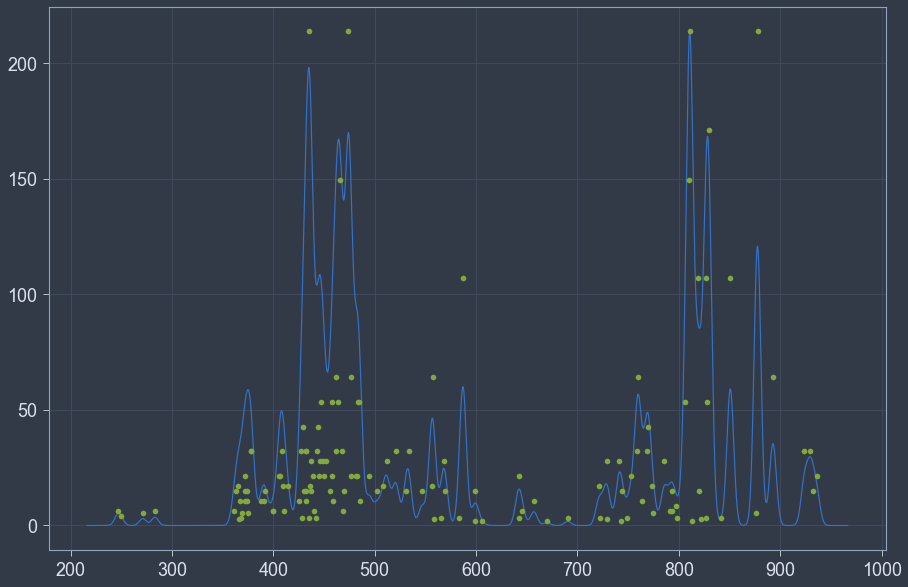

In [20]:
# Teste do método

#  Making a linearly spaced (on the wavelenght) array with the values of the intensity of the lines
# to do a convolution

# Change "Data" to whichever convolution you want to generate
# Change N to change dX= L/(N-1)
Data= Data_Kr

L= Data[0][-1]-Data[0][0] 
N= 10* int(L)
X= np.linspace(Data[0][0], Data[0][-1], N  )
Y= np.zeros(N)
dX= L/(N-1)

# Creating a map from the original spectral lines list to the new linear one
ind= np.array((Data[0]-Data[0][0])/dX, dtype=int)

for i in range(len(Data[0])):
    Y[ind[i]]= Data[1][i]

# Generating the gaussian (normalized) with a grid with width dX
# When x = 9*sig the gaussian is ~0 (2.5E-18, the machine limit)
# We use sig= 3.38 +- 0.08 (determined from the spectrometer data of He)
sigma= 3.38

def Gauss(x,sigma):
    return np.exp(-(x/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

X_Gauss= np.arange(-9*sigma,9*sigma+dX,dX)
Y_Gauss= Gauss( X_Gauss, sigma )
Conv = np.convolve(Y, Y_Gauss, mode="full")

plt.figure(figsize=(15,10))
# It's necesseray to set the "0" of the graph: (points - half the points of the convolution)dX + X_0
plt.plot( (np.arange(len(Conv))- int(len(X_Gauss)/2))*dX + Data[0][0], Conv[::1])
# Ploting original lines for comparison
Norm= np.max(Conv)/np.max(Data[1]) 
plt.plot( Data[0], Data[1]*Norm, "o"  )

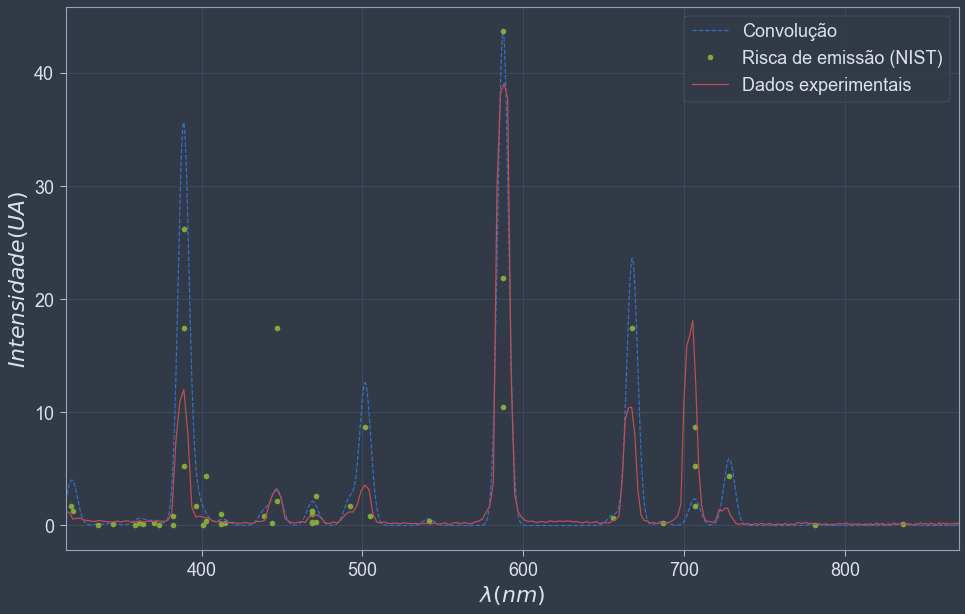

In [24]:
# Func version (esta é a utilizada)
def FullConv(Data):
    """
    -input
    Data: a (2;N) array Data[0] must be the x, Data[0] must be the y

    -output
    Conv_X, Conv
    """
    sigma= 3.38
    def Gauss(x):
        return np.exp(-(x/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

    L= Data[0][-1]-Data[0][0] 
    N= 10* int(L)
    X= np.linspace(Data[0][0], Data[0][-1], N  )
    Y= np.zeros(N)
    dX= L/(N-1)

    # Creating a map from the original spectral lines list to the new linear one
    ind= np.array((Data[0]-Data[0][0])/dX, dtype=int)

    for i in range(len(Data[0])):
        Y[ind[i]]= Data[1][i]

    # Generating the gaussian (normalized) with a grid with width dX
    # When x = 9*sig the gaussian is ~0 (2.5E-18, the machine limit)
    # We use sig= 3.38 +- 0.08 (determined from the spectrometer data)
    sigma= 3.38

    X_Gauss= np.arange(-9*sigma,9*sigma+dX,dX)
    Y_Gauss= Gauss( X_Gauss )

    Conv = np.convolve(Y, Y_Gauss, mode="full")
    Conv_X= (np.arange(len(Conv))- int(len(X_Gauss)/2))*dX + Data[0][0]

    return Conv_X, Conv

# Setup to run    He and Kr
Data= np.copy(Data_He)
ExpData= He

Filter= 0 # Filters out any spectral line of intensity smaller than "Filter"
Data[1]= np.where(Data[1]<Filter, 0, Data[1])

x,y = FullConv(Data)
plt.figure(figsize=(16,10))
plt.plot(x,y, "--",label="Convolução")
plt.plot(Data[0],Data[1]*np.max(y)/np.max(Data[1]), "o", label="Risca de emissão (NIST)")
plt.plot( F(np.arange(len(ExpData))), (ExpData- np.min(ExpData))*np.max(y)/np.max(ExpData), label="Dados experimentais" )
plt.xlabel("$ \\lambda (nm) $")
plt.ylabel("$ Intensidade (UA) $")
plt.legend()
pix= np.arange(len(ExpData))
plt.xlim(F(pix[0]),F(pix[-1]))
plt.show()

Determinar $R=\frac{\lambda}{\Delta \lambda}$, poder resolvente (inverso do erro relativo). $\lambda$ é o comprimento de onda, $\Delta\lambda$ é o erro na medição desse comprimento de onda.

Resolução em FWHM $res= 2*\sqrt{2*ln(2)}*\sigma $

Entre 8.15 e 7.77 de resolução espectral (FWHM) media ao longo do espectro

# WIP

[4.56202969e-17 5.95298988e-17 7.76124155e-17 ... 9.64071197e-17
 7.39283810e-17 5.66411812e-17]


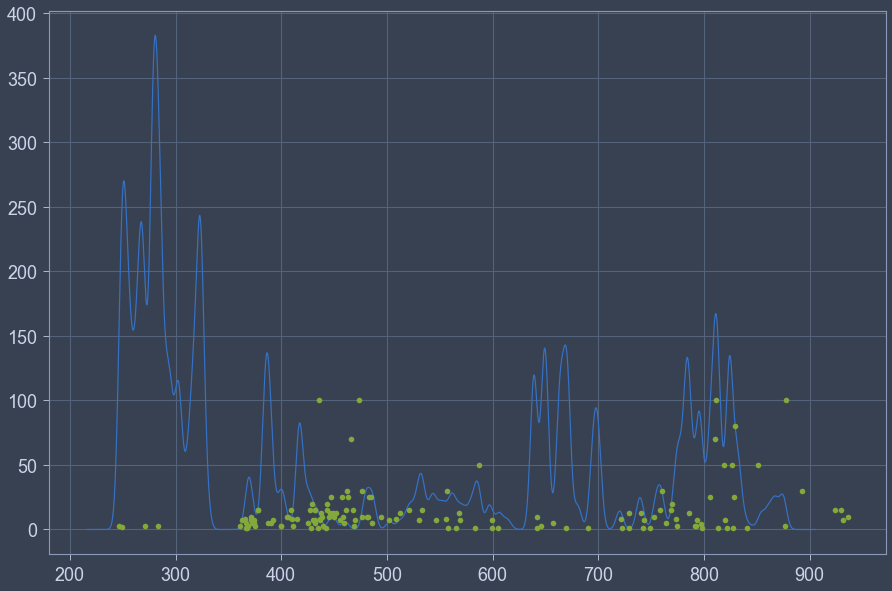

In [16]:
# Generating the gaussian (normalized) with a grid with width dX
# When x = 9*sig the gaussian is ~0 (2.5E-18, the machine limit)
# We use sig= 3.38 +- 0.08
sigma= 3.38
def Gauss(x):
    return np.exp(-(x/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

X_Gauss= np.arange(-9*sigma,9*sigma+dX,dX)
Y_Gauss= Gauss( X_Gauss )
# plt.plot(X_Gauss,Y_Gauss)
# print(Y_Gauss[0])

Conv = np.convolve(Y, Y_Gauss, mode="full")
print(Conv)
# plt.plot(X, Conv)
plt.figure(figsize=(15,10))
# It's necesseray to set the "0" of the graph
plt.plot( (np.arange(len(Conv))- int(len(X_Gauss)/2))*dX + Data[0][0], Conv[::1])
plt.plot( Data[0], Data[1]/10, "o"  )

In [7]:
x=(94,112,130)
y=(470,525,624)
deg= 2

aj= np.polyfit(x,y,deg)[::-1]
np.polynomial.polynomial.Polynomial( aj )

Polynomial([ 8.97641975e+02, -1.09320988e+01,  6.79012346e-02], domain=[-1,  1], window=[-1,  1])